In [1]:
import random
import time
import os

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torch.nn import BCEWithLogitsLoss
from imutils.paths import list_images
from matplotlib import pyplot as plt
from torchvision import transforms
from torch.optim import Adam
from tqdm.auto import tqdm
import numpy as np
import torch

from misc.dataset import SegmentationDataset
from misc.UNet import UNet
from misc import predict
from misc import config

/root/anaconda3/envs/torch_1.x/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_image_paths = sorted(list_images(config.TRAIN_IMAGE_PATH))
train_mask_paths  = sorted(list_images(config.TRAIN_MASK_PATH))

train_image, test_image, train_mask, test_mask = train_test_split(
                                                    train_image_paths, train_mask_paths,
                                                    test_size = 0.15, random_state = 99
                                                )

In [3]:
transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((config.INPUT_IMAGE_HEIGHT, config.INPUT_IMAGE_WIDTH)),
                transforms.ToTensor()
            ])


train_dataset = SegmentationDataset(train_image, train_mask, transform = transform)
test_dataset  = SegmentationDataset( test_image,  test_mask, transform = transform)

train_loader  = DataLoader(train_dataset, shuffle = True, batch_size = config.BATCH_SIZE,
                           pin_memory = config.PIN_MEMORY, num_workers = os.cpu_count())

test_loader   = DataLoader(test_dataset, shuffle = False, batch_size = config.BATCH_SIZE,
                           pin_memory = config.PIN_MEMORY, num_workers = os.cpu_count())

In [4]:
unet      = UNet().to(config.DEVICE)
loss_func = BCEWithLogitsLoss()
optimizer = Adam(unet.parameters(), lr = config.INIT_LR)

train_step = len(train_dataset) // config.BATCH_SIZE
test_step  = len(test_dataset)  // config.BATCH_SIZE

H          = {'train_loss' : [], 'test_loss' : []}

In [5]:
for epoch in tqdm(range(config.EPOCHS)):

    unet.train()
    train_loss, test_loss = 0, 0

    for idx, (image, mask) in enumerate(train_loader):

        image = image.to(config.DEVICE)
        mask  =  mask.to(config.DEVICE)

        pred  = unet(image)
        loss  = loss_func(pred, mask)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss


    with torch.no_grad():
        unet.eval()
        for image, mask in test_loader:

            image, mask = image.to(config.DEVICE), mask.to(config.DEVICE)
            pred        = unet(image)

            test_loss  += loss_func(pred, mask)

    avg_train_loss = train_loss / train_step
    avb_test_loss  = test_loss  / test_step

    # update our training history
    H["train_loss"].append(avg_train_loss.cpu().detach().numpy())
    H["test_loss"].append(avb_test_loss.cpu().detach().numpy())
    
    # print the model training and validation information
    print("[INFO] EPOCH: {}/{}".format(epoch + 1, config.EPOCHS))
    print("Train loss: {:.3f}, Test loss: {:.3f}".format(
        avg_train_loss, avb_test_loss))
    

  1%|          | 1/100 [00:43<1:12:27, 43.91s/it]

[INFO] EPOCH: 1/100
Train loss: 0.592, Test loss: 0.665


  2%|▏         | 2/100 [01:25<1:09:47, 42.73s/it]

[INFO] EPOCH: 2/100
Train loss: 0.563, Test loss: 0.628


  3%|▎         | 3/100 [02:10<1:10:27, 43.59s/it]

[INFO] EPOCH: 3/100
Train loss: 0.533, Test loss: 0.598


  4%|▍         | 4/100 [02:50<1:07:38, 42.27s/it]

[INFO] EPOCH: 4/100
Train loss: 0.498, Test loss: 0.516


  5%|▌         | 5/100 [03:29<1:05:09, 41.15s/it]

[INFO] EPOCH: 5/100
Train loss: 0.450, Test loss: 0.455


  6%|▌         | 6/100 [04:13<1:05:36, 41.88s/it]

[INFO] EPOCH: 6/100
Train loss: 0.406, Test loss: 0.427


  7%|▋         | 7/100 [04:51<1:02:56, 40.61s/it]

[INFO] EPOCH: 7/100
Train loss: 0.396, Test loss: 0.436


  8%|▊         | 8/100 [05:30<1:01:31, 40.13s/it]

[INFO] EPOCH: 8/100
Train loss: 0.386, Test loss: 0.444


  9%|▉         | 9/100 [06:11<1:01:35, 40.61s/it]

[INFO] EPOCH: 9/100
Train loss: 0.378, Test loss: 0.408


 10%|█         | 10/100 [06:52<1:00:57, 40.63s/it]

[INFO] EPOCH: 10/100
Train loss: 0.373, Test loss: 0.423


 13%|█▎        | 13/100 [08:55<59:47, 41.24s/it]

[INFO] EPOCH: 13/100
Train loss: 0.355, Test loss: 0.429


 14%|█▍        | 14/100 [09:38<59:40, 41.64s/it]

[INFO] EPOCH: 14/100
Train loss: 0.363, Test loss: 0.377


 15%|█▌        | 15/100 [10:20<59:16, 41.84s/it]

[INFO] EPOCH: 15/100
Train loss: 0.342, Test loss: 0.414


 16%|█▌        | 16/100 [11:02<58:25, 41.73s/it]

[INFO] EPOCH: 16/100
Train loss: 0.333, Test loss: 0.471


 17%|█▋        | 17/100 [11:46<58:38, 42.39s/it]

[INFO] EPOCH: 17/100
Train loss: 0.347, Test loss: 0.368


 18%|█▊        | 18/100 [12:28<58:03, 42.48s/it]

[INFO] EPOCH: 18/100
Train loss: 0.328, Test loss: 0.383


 19%|█▉        | 19/100 [13:10<56:57, 42.20s/it]

[INFO] EPOCH: 19/100
Train loss: 0.318, Test loss: 0.334


 20%|██        | 20/100 [13:52<56:08, 42.11s/it]

[INFO] EPOCH: 20/100
Train loss: 0.302, Test loss: 0.347


 21%|██        | 21/100 [14:34<55:31, 42.17s/it]

[INFO] EPOCH: 21/100
Train loss: 0.296, Test loss: 0.429


 22%|██▏       | 22/100 [15:16<54:46, 42.14s/it]

[INFO] EPOCH: 22/100
Train loss: 0.300, Test loss: 0.318


 23%|██▎       | 23/100 [15:58<53:57, 42.05s/it]

[INFO] EPOCH: 23/100
Train loss: 0.295, Test loss: 0.316


 24%|██▍       | 24/100 [16:40<53:18, 42.09s/it]

[INFO] EPOCH: 24/100
Train loss: 0.288, Test loss: 0.323


 25%|██▌       | 25/100 [17:24<53:07, 42.50s/it]

[INFO] EPOCH: 25/100
Train loss: 0.282, Test loss: 0.330


 26%|██▌       | 26/100 [18:07<52:37, 42.67s/it]

[INFO] EPOCH: 26/100
Train loss: 0.287, Test loss: 0.339


 27%|██▋       | 27/100 [18:49<51:43, 42.51s/it]

[INFO] EPOCH: 27/100
Train loss: 0.285, Test loss: 0.316


 28%|██▊       | 28/100 [19:31<50:58, 42.47s/it]

[INFO] EPOCH: 28/100
Train loss: 0.291, Test loss: 0.329


 29%|██▉       | 29/100 [20:13<50:07, 42.36s/it]

[INFO] EPOCH: 29/100
Train loss: 0.291, Test loss: 0.327


 30%|███       | 30/100 [20:56<49:34, 42.50s/it]

[INFO] EPOCH: 30/100
Train loss: 0.289, Test loss: 0.337


 31%|███       | 31/100 [21:44<50:39, 44.04s/it]

[INFO] EPOCH: 31/100
Train loss: 0.282, Test loss: 0.321


 32%|███▏      | 32/100 [22:26<49:16, 43.47s/it]

[INFO] EPOCH: 32/100
Train loss: 0.277, Test loss: 0.314


 33%|███▎      | 33/100 [23:08<47:57, 42.95s/it]

[INFO] EPOCH: 33/100
Train loss: 0.274, Test loss: 0.305


 34%|███▍      | 34/100 [23:49<46:48, 42.55s/it]

[INFO] EPOCH: 34/100
Train loss: 0.274, Test loss: 0.367


 35%|███▌      | 35/100 [24:31<45:47, 42.27s/it]

[INFO] EPOCH: 35/100
Train loss: 0.282, Test loss: 0.306


 36%|███▌      | 36/100 [25:12<44:48, 42.01s/it]

[INFO] EPOCH: 36/100
Train loss: 0.270, Test loss: 0.309


 37%|███▋      | 37/100 [25:53<43:33, 41.49s/it]

[INFO] EPOCH: 37/100
Train loss: 0.272, Test loss: 0.305


 38%|███▊      | 38/100 [26:37<43:38, 42.23s/it]

[INFO] EPOCH: 38/100
Train loss: 0.264, Test loss: 0.314


 39%|███▉      | 39/100 [27:22<44:00, 43.29s/it]

[INFO] EPOCH: 39/100
Train loss: 0.274, Test loss: 0.306


 40%|████      | 40/100 [28:06<43:30, 43.50s/it]

[INFO] EPOCH: 40/100
Train loss: 0.274, Test loss: 0.358


 41%|████      | 41/100 [28:49<42:37, 43.35s/it]

[INFO] EPOCH: 41/100
Train loss: 0.277, Test loss: 0.301


 42%|████▏     | 42/100 [29:32<41:49, 43.26s/it]

[INFO] EPOCH: 42/100
Train loss: 0.261, Test loss: 0.300


 43%|████▎     | 43/100 [30:12<40:09, 42.27s/it]

[INFO] EPOCH: 43/100
Train loss: 0.263, Test loss: 0.311


 44%|████▍     | 44/100 [30:54<39:19, 42.13s/it]

[INFO] EPOCH: 44/100
Train loss: 0.268, Test loss: 0.321


 45%|████▌     | 45/100 [31:37<38:54, 42.45s/it]

[INFO] EPOCH: 45/100
Train loss: 0.266, Test loss: 0.307


 47%|████▋     | 47/100 [33:11<39:33, 44.79s/it]

[INFO] EPOCH: 47/100
Train loss: 0.255, Test loss: 0.301


 48%|████▊     | 48/100 [33:59<39:23, 45.46s/it]

[INFO] EPOCH: 48/100
Train loss: 0.260, Test loss: 0.341


 49%|████▉     | 49/100 [34:46<39:11, 46.12s/it]

[INFO] EPOCH: 49/100
Train loss: 0.267, Test loss: 0.307


 50%|█████     | 50/100 [35:34<38:47, 46.55s/it]

[INFO] EPOCH: 50/100
Train loss: 0.260, Test loss: 0.304


 51%|█████     | 51/100 [36:20<37:59, 46.53s/it]

[INFO] EPOCH: 51/100
Train loss: 0.256, Test loss: 0.304


 52%|█████▏    | 52/100 [37:07<37:23, 46.75s/it]

[INFO] EPOCH: 52/100
Train loss: 0.249, Test loss: 0.298


 53%|█████▎    | 53/100 [37:55<36:45, 46.93s/it]

[INFO] EPOCH: 53/100
Train loss: 0.252, Test loss: 0.292


 54%|█████▍    | 54/100 [38:42<36:06, 47.10s/it]

[INFO] EPOCH: 54/100
Train loss: 0.255, Test loss: 0.321


 55%|█████▌    | 55/100 [39:31<35:36, 47.48s/it]

[INFO] EPOCH: 55/100
Train loss: 0.256, Test loss: 0.296


 56%|█████▌    | 56/100 [40:19<35:04, 47.83s/it]

[INFO] EPOCH: 56/100
Train loss: 0.252, Test loss: 0.294


 59%|█████▉    | 59/100 [42:43<32:41, 47.84s/it]

[INFO] EPOCH: 59/100
Train loss: 0.266, Test loss: 0.319


 60%|██████    | 60/100 [43:32<32:08, 48.21s/it]

[INFO] EPOCH: 60/100
Train loss: 0.254, Test loss: 0.295


 61%|██████    | 61/100 [44:19<31:10, 47.97s/it]

[INFO] EPOCH: 61/100
Train loss: 0.256, Test loss: 0.286


 62%|██████▏   | 62/100 [45:06<30:10, 47.64s/it]

[INFO] EPOCH: 62/100
Train loss: 0.253, Test loss: 0.288


 63%|██████▎   | 63/100 [45:56<29:42, 48.17s/it]

[INFO] EPOCH: 63/100
Train loss: 0.246, Test loss: 0.294


 64%|██████▍   | 64/100 [46:43<28:47, 47.99s/it]

[INFO] EPOCH: 64/100
Train loss: 0.252, Test loss: 0.287


 65%|██████▌   | 65/100 [47:31<27:55, 47.87s/it]

[INFO] EPOCH: 65/100
Train loss: 0.243, Test loss: 0.304


 66%|██████▌   | 66/100 [48:17<26:50, 47.37s/it]

[INFO] EPOCH: 66/100
Train loss: 0.244, Test loss: 0.299


 67%|██████▋   | 67/100 [49:04<26:02, 47.34s/it]

[INFO] EPOCH: 67/100
Train loss: 0.239, Test loss: 0.290


 68%|██████▊   | 68/100 [49:55<25:43, 48.23s/it]

[INFO] EPOCH: 68/100
Train loss: 0.240, Test loss: 0.287


 69%|██████▉   | 69/100 [50:42<24:51, 48.10s/it]

[INFO] EPOCH: 69/100
Train loss: 0.235, Test loss: 0.303


 70%|███████   | 70/100 [51:33<24:22, 48.76s/it]

[INFO] EPOCH: 70/100
Train loss: 0.248, Test loss: 0.312


 71%|███████   | 71/100 [52:21<23:33, 48.74s/it]

[INFO] EPOCH: 71/100
Train loss: 0.256, Test loss: 0.286


 72%|███████▏  | 72/100 [53:07<22:14, 47.67s/it]

[INFO] EPOCH: 72/100
Train loss: 0.241, Test loss: 0.288


 73%|███████▎  | 73/100 [53:51<21:03, 46.81s/it]

[INFO] EPOCH: 73/100
Train loss: 0.246, Test loss: 0.290


 74%|███████▍  | 74/100 [54:37<20:09, 46.51s/it]

[INFO] EPOCH: 74/100
Train loss: 0.237, Test loss: 0.289


 75%|███████▌  | 75/100 [55:25<19:30, 46.84s/it]

[INFO] EPOCH: 75/100
Train loss: 0.241, Test loss: 0.280


 76%|███████▌  | 76/100 [56:06<18:02, 45.12s/it]

[INFO] EPOCH: 76/100
Train loss: 0.235, Test loss: 0.279


 77%|███████▋  | 77/100 [56:49<17:00, 44.35s/it]

[INFO] EPOCH: 77/100
Train loss: 0.240, Test loss: 0.288


 78%|███████▊  | 78/100 [57:33<16:14, 44.32s/it]

[INFO] EPOCH: 78/100
Train loss: 0.235, Test loss: 0.280


 79%|███████▉  | 79/100 [58:14<15:12, 43.45s/it]

[INFO] EPOCH: 79/100
Train loss: 0.233, Test loss: 0.280


 80%|████████  | 80/100 [58:56<14:17, 42.88s/it]

[INFO] EPOCH: 80/100
Train loss: 0.233, Test loss: 0.290


 81%|████████  | 81/100 [59:37<13:27, 42.48s/it]

[INFO] EPOCH: 81/100
Train loss: 0.234, Test loss: 0.306


 82%|████████▏ | 82/100 [1:00:21<12:51, 42.86s/it]

[INFO] EPOCH: 82/100
Train loss: 0.238, Test loss: 0.288


 83%|████████▎ | 83/100 [1:01:04<12:09, 42.93s/it]

[INFO] EPOCH: 83/100
Train loss: 0.228, Test loss: 0.283


 84%|████████▍ | 84/100 [1:01:44<11:13, 42.08s/it]

[INFO] EPOCH: 84/100
Train loss: 0.234, Test loss: 0.297


 85%|████████▌ | 85/100 [1:02:24<10:21, 41.45s/it]

[INFO] EPOCH: 85/100
Train loss: 0.239, Test loss: 0.287


 86%|████████▌ | 86/100 [1:03:05<09:39, 41.41s/it]

[INFO] EPOCH: 86/100
Train loss: 0.245, Test loss: 0.300


 87%|████████▋ | 87/100 [1:03:47<09:00, 41.59s/it]

[INFO] EPOCH: 87/100
Train loss: 0.238, Test loss: 0.285


 88%|████████▊ | 88/100 [1:04:29<08:19, 41.64s/it]

[INFO] EPOCH: 88/100
Train loss: 0.230, Test loss: 0.279


 89%|████████▉ | 89/100 [1:05:09<07:32, 41.18s/it]

[INFO] EPOCH: 89/100
Train loss: 0.233, Test loss: 0.286


 90%|█████████ | 90/100 [1:05:51<06:52, 41.28s/it]

[INFO] EPOCH: 90/100
Train loss: 0.235, Test loss: 0.285


 91%|█████████ | 91/100 [1:06:31<06:08, 40.93s/it]

[INFO] EPOCH: 91/100
Train loss: 0.235, Test loss: 0.300


 92%|█████████▏| 92/100 [1:07:10<05:23, 40.38s/it]

[INFO] EPOCH: 92/100
Train loss: 0.231, Test loss: 0.281


 93%|█████████▎| 93/100 [1:07:52<04:46, 40.96s/it]

[INFO] EPOCH: 93/100
Train loss: 0.229, Test loss: 0.281


 94%|█████████▍| 94/100 [1:08:32<04:02, 40.42s/it]

[INFO] EPOCH: 94/100
Train loss: 0.225, Test loss: 0.277


 95%|█████████▌| 95/100 [1:09:10<03:19, 39.97s/it]

[INFO] EPOCH: 95/100
Train loss: 0.226, Test loss: 0.279


 96%|█████████▌| 96/100 [1:09:50<02:39, 39.76s/it]

[INFO] EPOCH: 96/100
Train loss: 0.222, Test loss: 0.288


 97%|█████████▋| 97/100 [1:10:30<01:59, 39.99s/it]

[INFO] EPOCH: 97/100
Train loss: 0.227, Test loss: 0.282


 98%|█████████▊| 98/100 [1:11:11<01:20, 40.20s/it]

[INFO] EPOCH: 98/100
Train loss: 0.222, Test loss: 0.286


 99%|█████████▉| 99/100 [1:11:51<00:40, 40.25s/it]

[INFO] EPOCH: 99/100
Train loss: 0.225, Test loss: 0.277


100%|██████████| 100/100 [1:12:32<00:00, 43.52s/it]

[INFO] EPOCH: 100/100
Train loss: 0.225, Test loss: 0.293


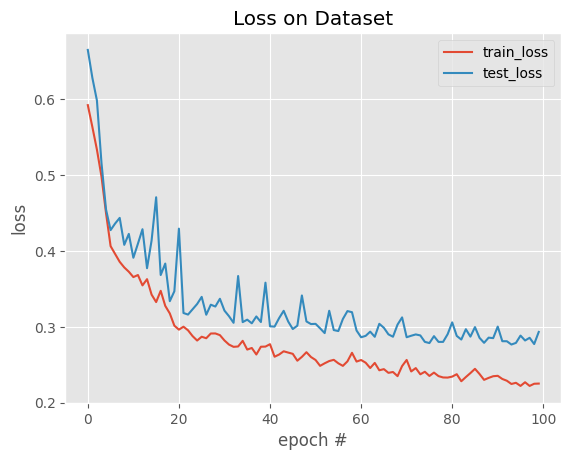

In [6]:
plt.style.use('ggplot')
plt.figure()

plt.plot(H['train_loss'], label = 'train_loss')
plt.plot(H['test_loss'] , label =  'test_loss')

plt.title('Loss on Dataset')
plt.xlabel('epoch #')
plt.ylabel('loss')
plt.legend(loc = 'best')
plt.savefig(config.PLOT_PATH)

torch.save(unet, config.MODEL_PATH)

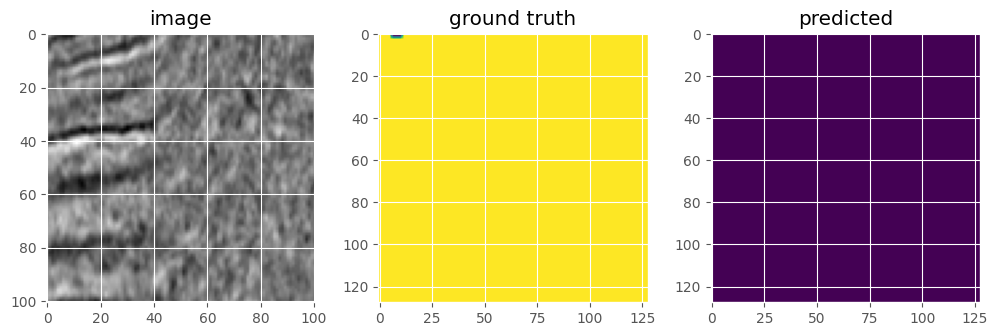

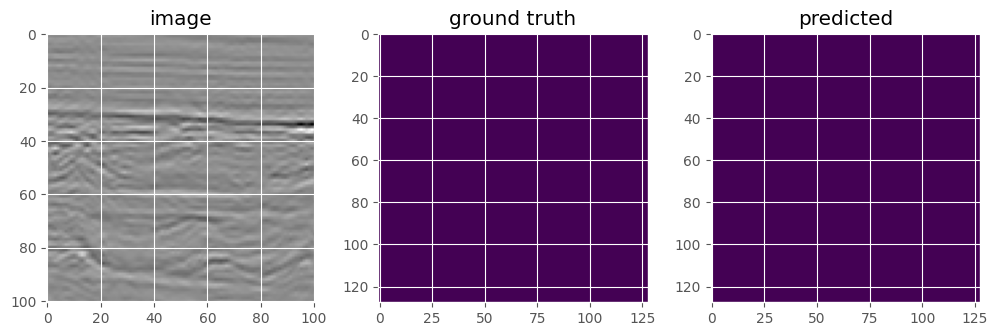

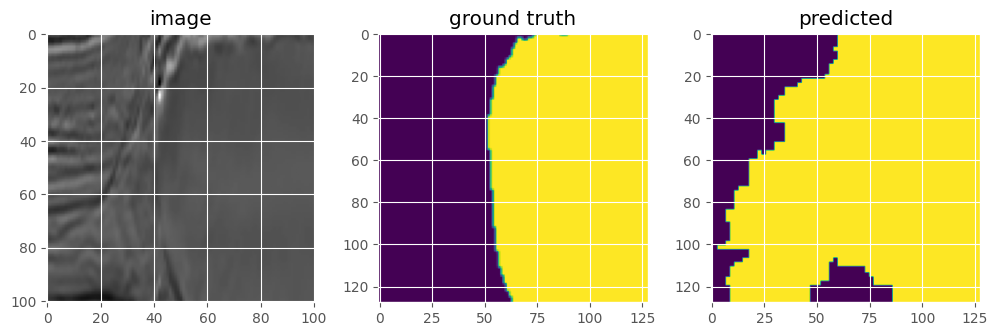

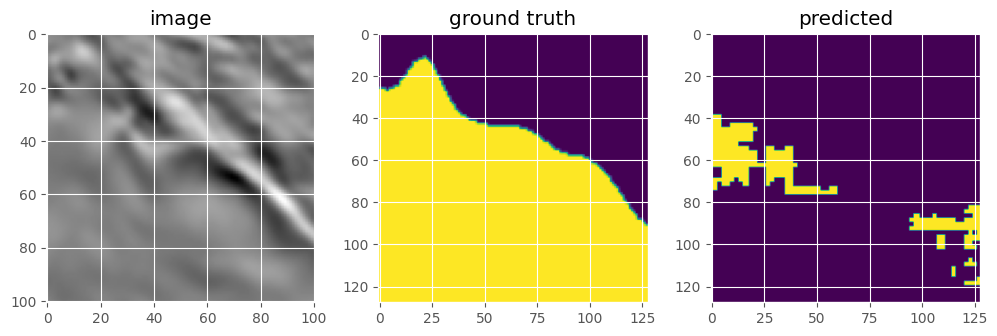

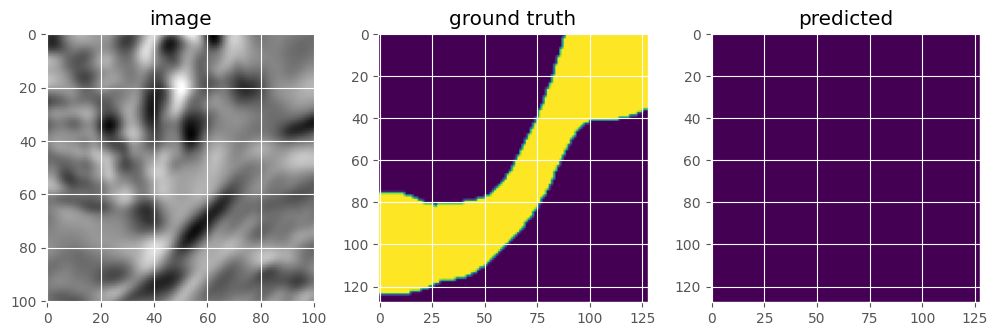

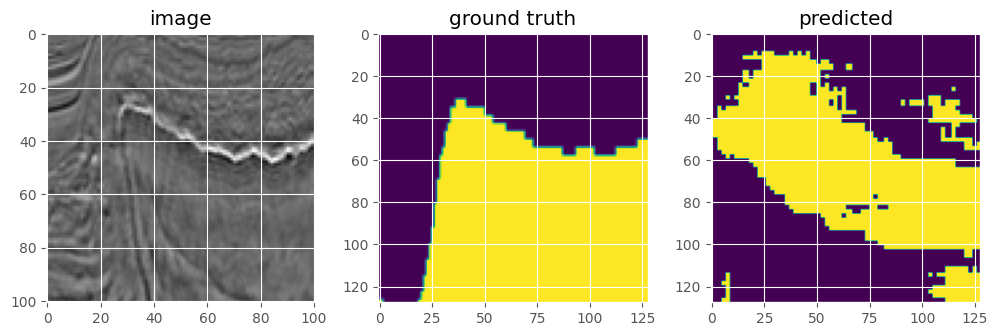

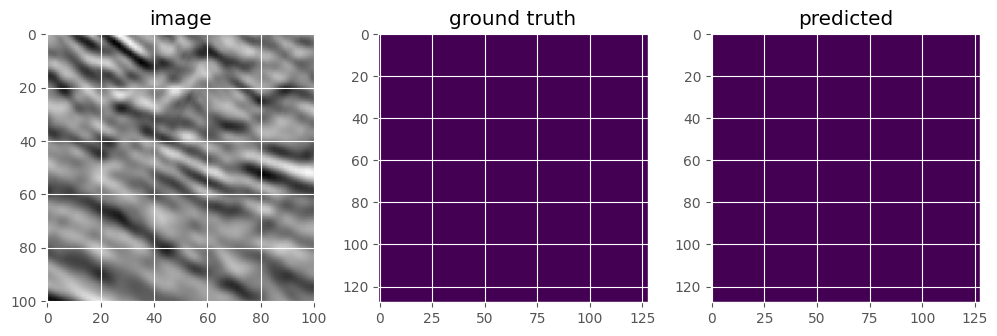

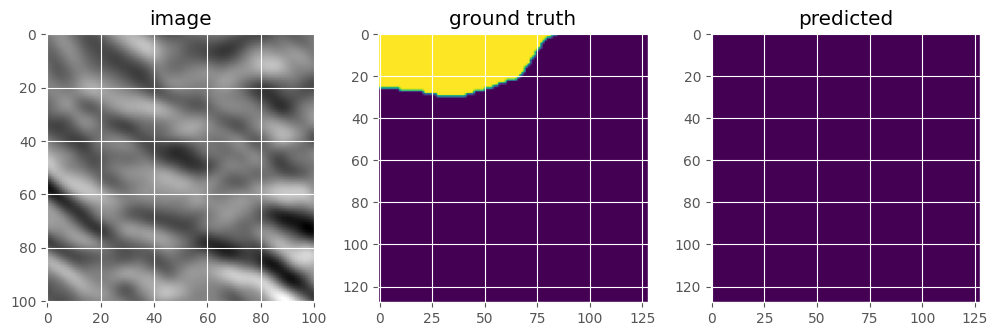

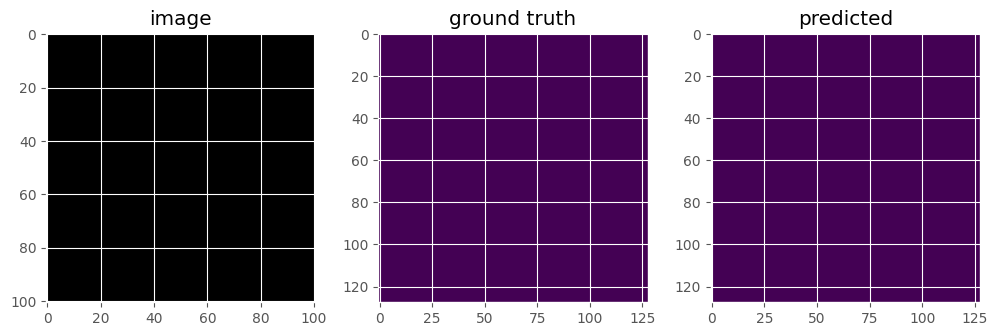

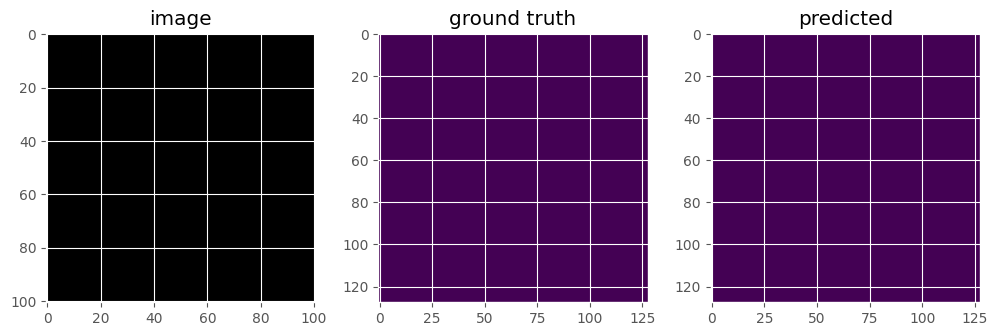

In [7]:
test_paths = np.random.choice(test_image, size = 10)

for test_path in test_paths:

    predict.evaluation(unet, test_path)